In [2]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO

In [3]:
data_flag = "retinamnist"
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [52]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, root="../data/")
valid_dataset = DataClass(split='val', transform=data_transform, download=download, root="../data/")
test_dataset = DataClass(split='test', transform=data_transform, download=download, root="../data/")

BATCH_SIZE = 128
# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: ../data/retinamnist.npz
Using downloaded and verified file: ../data/retinamnist.npz
Using downloaded and verified file: ../data/retinamnist.npz


In [53]:
img_batch, label_batch = next(iter(train_loader))

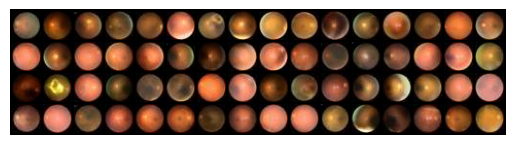

In [55]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

plt.imshow(make_grid(img_batch, nrow=16).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
from src.model import VAE, SimpleCNNClassifier
from src.trainer import CDVAETrainer, SimpleCNNTrainer
from src.model import interpolate_latent

%load_ext autoreload
%autoreload 2

In [182]:
cnn = SimpleCNNClassifier(n_class=5, in_channel=3).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = SimpleCNNTrainer(cnn, optimizer, criterion, 3, device)

In [183]:
trainer.fit(16, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 2/2 [00:00<00:00, 222.03it/s]


val_aupr: {0: 0.757, 1: 0.213, 2: 0.344, 3: 0.492, 4: 0.057}
0.373
val_auroc: {0: 0.756, 1: 0.679, 2: 0.675, 3: 0.802, 4: 0.52}
0.686


val-epoch 3: 100%|██████████| 2/2 [00:00<00:00, 250.08it/s]


val_aupr: {0: 0.864, 1: 0.417, 2: 0.437, 3: 0.364, 4: 0.127}
0.442
val_auroc: {0: 0.814, 1: 0.828, 2: 0.703, 3: 0.744, 4: 0.757}
0.769


val-epoch 6: 100%|██████████| 2/2 [00:00<00:00, 166.67it/s]


val_aupr: {0: 0.87, 1: 0.43, 2: 0.458, 3: 0.349, 4: 0.227}
0.467
val_auroc: {0: 0.825, 1: 0.826, 2: 0.736, 3: 0.711, 4: 0.792}
0.778


val-epoch 9: 100%|██████████| 2/2 [00:00<00:00, 199.99it/s]


val_aupr: {0: 0.852, 1: 0.435, 2: 0.503, 3: 0.366, 4: 0.353}
0.502
val_auroc: {0: 0.801, 1: 0.826, 2: 0.759, 3: 0.706, 4: 0.801}
0.779


val-epoch 12: 100%|██████████| 2/2 [00:00<00:00, 222.00it/s]


val_aupr: {0: 0.86, 1: 0.442, 2: 0.487, 3: 0.336, 4: 0.439}
0.513
val_auroc: {0: 0.812, 1: 0.822, 2: 0.772, 3: 0.708, 4: 0.813}
0.785


val-epoch 15: 100%|██████████| 2/2 [00:00<00:00, 222.25it/s]

val_aupr: {0: 0.852, 1: 0.423, 2: 0.536, 3: 0.312, 4: 0.436}
0.512
val_auroc: {0: 0.804, 1: 0.823, 2: 0.768, 3: 0.708, 4: 0.806}
0.782


In [184]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 7/7 [00:00<00:00, 210.18it/s]

val_aupr: {0: 0.804, 1: 0.211, 2: 0.321, 3: 0.366, 4: 0.09}
0.358
val_auroc: {0: 0.823, 1: 0.637, 2: 0.694, 3: 0.782, 4: 0.664}
0.72


In [166]:
Z_DIM = 32
TEMP = 0.005
ALPHA = [1000, 1000]
LABEL_FLIPPING = True
vae = VAE(total_z_dim=Z_DIM, in_channel=3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=2e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=40,
    device=device,
)

In [167]:
trainer.fit(201, train_loader, test_loader)

val-epoch 0: 100%|██████████| 7/7 [00:00<00:00, 120.69it/s]


val_recontr_loss=303.298, val_kl_c=0.061, val_kl_s=0.064, val_c_loss=1.315, val_s_loss=0.425
gMIG: -0.008


val-epoch 40: 100%|██████████| 7/7 [00:00<00:00, 130.11it/s]


val_recontr_loss=126.618, val_kl_c=1.797, val_kl_s=2.845, val_c_loss=1.573, val_s_loss=0.380
gMIG: 0.019


val-epoch 80: 100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


val_recontr_loss=95.287, val_kl_c=1.653, val_kl_s=3.091, val_c_loss=2.554, val_s_loss=0.423
gMIG: 0.01


val-epoch 120: 100%|██████████| 7/7 [00:00<00:00, 121.98it/s]


val_recontr_loss=73.933, val_kl_c=1.614, val_kl_s=3.100, val_c_loss=2.636, val_s_loss=0.401
gMIG: 0.032


val-epoch 160: 100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


val_recontr_loss=58.267, val_kl_c=1.723, val_kl_s=3.337, val_c_loss=2.529, val_s_loss=0.408
gMIG: 0.027


val-epoch 200: 100%|██████████| 7/7 [00:00<00:00, 120.09it/s]


val_recontr_loss=45.631, val_kl_c=1.742, val_kl_s=3.103, val_c_loss=2.556, val_s_loss=0.442
gMIG: 0.043


In [168]:
mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label in tqdm(test_loader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

100%|██████████| 7/7 [00:00<00:00, 180.51it/s]


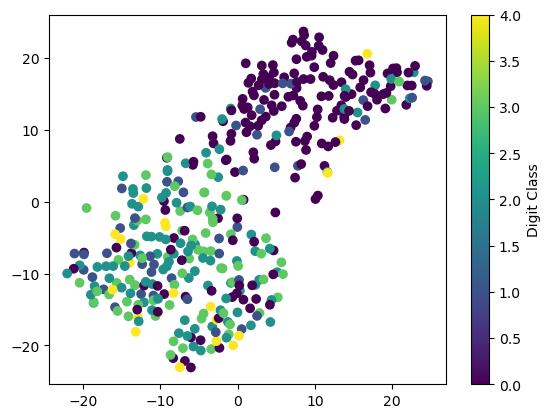

In [169]:
plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [170]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

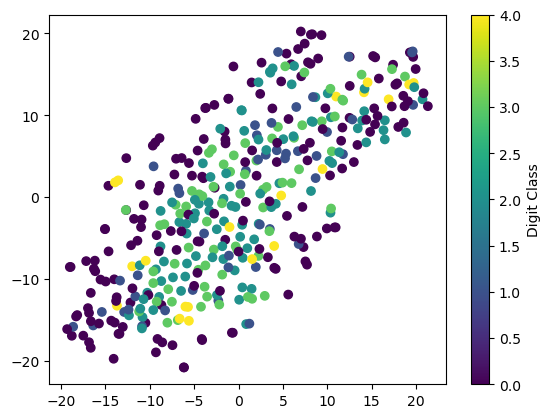

In [171]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [172]:
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [180]:
from src.trainer import DownstreamMLPTrainer
mlp = torch.nn.Sequential(
    torch.nn.Linear(int(Z_DIM / 2), 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 5),
).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = DownstreamMLPTrainer(vae, mlp, optimizer, criterion, 3, device)
trainer.fit(22, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 2/2 [00:00<00:00, 111.05it/s]


val_aupr: {0: 0.715, 1: 0.1, 2: 0.232, 3: 0.228, 4: 0.091}
0.273
val_auroc: {0: 0.687, 1: 0.444, 2: 0.523, 3: 0.586, 4: 0.69}
0.586


val-epoch 3: 100%|██████████| 2/2 [00:00<00:00, 196.19it/s]


val_aupr: {0: 0.853, 1: 0.231, 2: 0.269, 3: 0.238, 4: 0.116}
0.341
val_auroc: {0: 0.816, 1: 0.547, 2: 0.595, 3: 0.63, 4: 0.732}
0.664


val-epoch 6: 100%|██████████| 2/2 [00:00<00:00, 199.83it/s]


val_aupr: {0: 0.842, 1: 0.3, 2: 0.309, 3: 0.231, 4: 0.142}
0.365
val_auroc: {0: 0.804, 1: 0.65, 2: 0.656, 3: 0.65, 4: 0.719}
0.696


val-epoch 9: 100%|██████████| 2/2 [00:00<00:00, 223.20it/s]


val_aupr: {0: 0.835, 1: 0.236, 2: 0.336, 3: 0.225, 4: 0.228}
0.372
val_auroc: {0: 0.796, 1: 0.692, 2: 0.688, 3: 0.648, 4: 0.697}
0.704


val-epoch 12: 100%|██████████| 2/2 [00:00<00:00, 199.87it/s]


val_aupr: {0: 0.828, 1: 0.261, 2: 0.35, 3: 0.22, 4: 0.308}
0.393
val_auroc: {0: 0.784, 1: 0.707, 2: 0.708, 3: 0.648, 4: 0.689}
0.707


val-epoch 15: 100%|██████████| 2/2 [00:00<00:00, 222.50it/s]


val_aupr: {0: 0.826, 1: 0.252, 2: 0.355, 3: 0.218, 4: 0.305}
0.391
val_auroc: {0: 0.782, 1: 0.704, 2: 0.716, 3: 0.647, 4: 0.681}
0.706


val-epoch 18: 100%|██████████| 2/2 [00:00<00:00, 222.17it/s]


val_aupr: {0: 0.826, 1: 0.238, 2: 0.354, 3: 0.217, 4: 0.389}
0.405
val_auroc: {0: 0.782, 1: 0.701, 2: 0.716, 3: 0.643, 4: 0.689}
0.706


val-epoch 21: 100%|██████████| 2/2 [00:00<00:00, 222.20it/s]

val_aupr: {0: 0.826, 1: 0.229, 2: 0.354, 3: 0.221, 4: 0.39}
0.404
val_auroc: {0: 0.779, 1: 0.695, 2: 0.719, 3: 0.648, 4: 0.694}
0.707


In [181]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 7/7 [00:00<00:00, 192.67it/s]

val_aupr: {0: 0.724, 1: 0.158, 2: 0.3, 3: 0.361, 4: 0.171}
0.343
val_auroc: {0: 0.785, 1: 0.599, 2: 0.624, 3: 0.729, 4: 0.774}
0.702
